In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

import causalpy as cp

%load_ext autoreload
%autoreload 2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Variable Selection Priors and Instrumental Variable Designs

When building causal inference models, we often face a dilemma: we want to control for confounders to get unbiased causal estimates, but we're not always certain which variables are the true confounders. Include too few, and we risk omitted variable bias. Include too many, and we introduce noise that inflates our uncertainty or, worse, creates multicollinearity that destabilizes our estimates.

Traditional approaches force us to make hard choices upfront—which variables to include, which to exclude. This in ideal cases should be driven by theory. But what if we could let the data help us make these decisions while still maintaining the principled probabilistic framework of Bayesian inference? This is where variable selection priors come in. Let's first simulate some data with some natural confounding structure. 

In [2]:
def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and T (confounders)
    # X[2], X[3] affect ONLY T (instruments for T)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY = np.array(
        [0.5, -0.3, 0.0, 0.0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[2], X[3] excluded
    betaD = np.array(
        [0.7, 0.1, -0.4, 0.3, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[4] excluded
    p = len(betaY)

    # noise variances and correlation
    sigma_U = 3.0
    sigma_V = 3.0

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    T_cont = X @ betaD + V

    # latent variable for binary treatment
    T_latent = X @ betaD + V
    T_bin = np.random.binomial(n=1, p=inv_logit(T_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * T_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * T_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * T_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "T_cont": T_cont,
            "T_bin": T_bin,
        }
    )
    data["alpha"] = alpha_true + alpha_individual
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["T_cont_scaled"] = (data["T_cont"] - data["T_cont"].mean()) / data[
        "T_cont"
    ].std(ddof=1)
    data["T_bin_scaled"] = (data["T_bin"] - data["T_bin"].mean()) / data["T_bin"].std(
        ddof=1
    )
    return data


data = simulate_data()
instruments_data = data.copy()
features = [col for col in data.columns if "feature" in col]
formula = "Y_cont ~ T_cont + " + " + ".join(features)
instruments_formula = "T_cont ~ 1 + " + " + ".join(features)
data

,Y_cont,Y_bin,T_cont,T_bin,alpha,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,Y_cont_scaled,Y_bin_scaled,T_cont_scaled,T_bin_scaled
0,3.169837,-0.170346,1.113394,0,9.236102,1.294441,0.418241,0.536286,-0.615573,-1.173784,...,0.559393,1.111766,-0.216069,0.451496,-0.863189,0.319180,0.268475,-0.438362,0.347809,-1.022452
1,10.479049,6.662990,2.272020,1,3.787487,-0.885005,0.315013,0.810138,1.137214,0.203685,...,-0.017179,0.410818,0.670074,1.954944,0.888255,-0.506518,0.916637,1.321011,0.726014,0.977650
2,7.307821,4.118982,2.062946,1,3.311157,-1.075537,1.058536,1.908944,1.122914,0.611691,...,0.050641,1.245489,-1.070642,-0.060250,-1.857638,0.806913,0.635421,0.666008,0.657767,0.977650
3,9.781360,0.649647,4.043904,1,8.423450,0.969380,0.698199,0.314419,1.446987,-2.729092,...,-1.052429,1.143079,-1.757701,-1.167276,-0.164620,1.687004,0.854768,-0.227239,1.304402,0.977650
4,5.739283,6.812030,0.642417,1,6.613922,0.245569,-0.338491,0.814305,-0.859798,0.334968,...,-0.547622,0.778724,0.678956,1.715229,-0.439130,-0.238847,0.496327,1.359385,0.194070,0.977650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-5.099912,-0.870746,-1.409722,0,6.565630,0.226252,1.589653,0.056005,-0.386026,-0.462251,...,0.987633,0.246870,-0.202917,0.178579,0.763186,0.527462,-0.464865,-0.618693,-0.475800,-1.022452
2496,-32.742858,-7.337551,-8.468435,0,4.760520,-0.495792,0.546002,0.209072,0.666614,0.400847,...,-0.798775,-0.616483,0.431552,1.238957,0.957759,-0.583051,-2.916171,-2.283696,-2.779944,-1.022452
2497,6.759804,1.912040,1.615921,0,10.445934,1.778373,0.097808,-0.807658,0.380358,-0.455391,...,0.668040,1.471963,0.573966,-0.288768,-0.861025,0.372657,0.586824,0.097788,0.511847,-1.022452
2498,-11.249395,-1.938808,-3.103529,0,5.715321,-0.113872,0.747480,1.635159,-1.136585,-0.007239,...,-2.404202,-2.074570,0.022878,1.345018,0.705361,0.414329,-1.010186,-0.893686,-1.028702,-1.022452


CausalPy's  `Variable Selection` module provides a way to encode our uncertainty about variable relevance directly into the prior distribution. Rather than choosing which predictors to include, we specify priors that allow coefficients to be shrunk toward zero (or exactly zero) when the data doesn't support their inclusion. The key insight is that variable selection becomes part of the inference problem rather than a preprocessing step. The module offers two fundamentally different approaches to variable selection, each reflecting a different belief about how sparsity manifests in the world.

#### The Spike-and-Slab: Discrete Choices

The spike-and-slab prior embodies a binary worldview: each variable either matters or it doesn't. Mathematically, we express this as:

$$ \beta_{j} = \gamma_{j} \cdot \beta_{j_\text{raw}}$$

such that  

$$ \gamma_{j} \in \{0, 1\}$$

So we have the "spike"—the coefficient is exactly zero. When $\gamma_{j} = 1$, we have the "slab" i.e. the coefficient takes on a value from the raw distribution.
This approach appeals to our intuition about many real-world scenarios. Consider a propensity score model predicting whether someone receives a treatment. Some demographic variables might genuinely have no relationship with treatment assignment, while others are strongly predictive. The spike-and-slab says: let's let each variable clearly declare itself as relevant or irrelevant.

#### The Regularised Horseshoe: Gentle Moderation

The horseshoe prior takes a different philosophical stance. Instead of discrete selection, it says: effects exist on a continuum from negligible to substantial, and we should shrink them proportionally to their signal strength. Small effects get heavily shrunk (possibly to near-zero), while large effects escape shrinkage almost entirely.

$$ \beta_{j} = \tau \cdot \tilde{\lambda}_j \cdot \beta_{j\text{raw}}$$

where $\tau$ is a global shrinkage parameter shared across all coefficients, and $\tilde{\lambda}_j$ is local or specific to each coefficient and regularised so as to ensure finite variance. 


### Hyperparameters for Variable Selection Priors

You can control the behaviour of the variable selection priors through some of the hyperparameters available. For the spike and slab prior, the most important hyperparamers are `temperature`, `pi_alpha`, and `pi_beta`. 

Because our sampler doesn't like discrete variables, we're approximating a bernoulli outcome in our sampling to define the spike and slab. The approximation is governed by the `temperature` parameter. The default value of 0.1 works well in most cases, creating indicators that cluster near 0 or 1 without causing sampling difficulties.

The selection probability parameters `pi_alpha` and `pi_beta` encode your prior belief about sparsity. With both set to 2 (the default), you're placing a Beta(2,2) prior on π, the overall proportion of selected variables. This is symmetric around 0.5 but slightly concentrated there—you're saying "I don't know how many variables are relevant, but probably not all of them and probably not none of them."

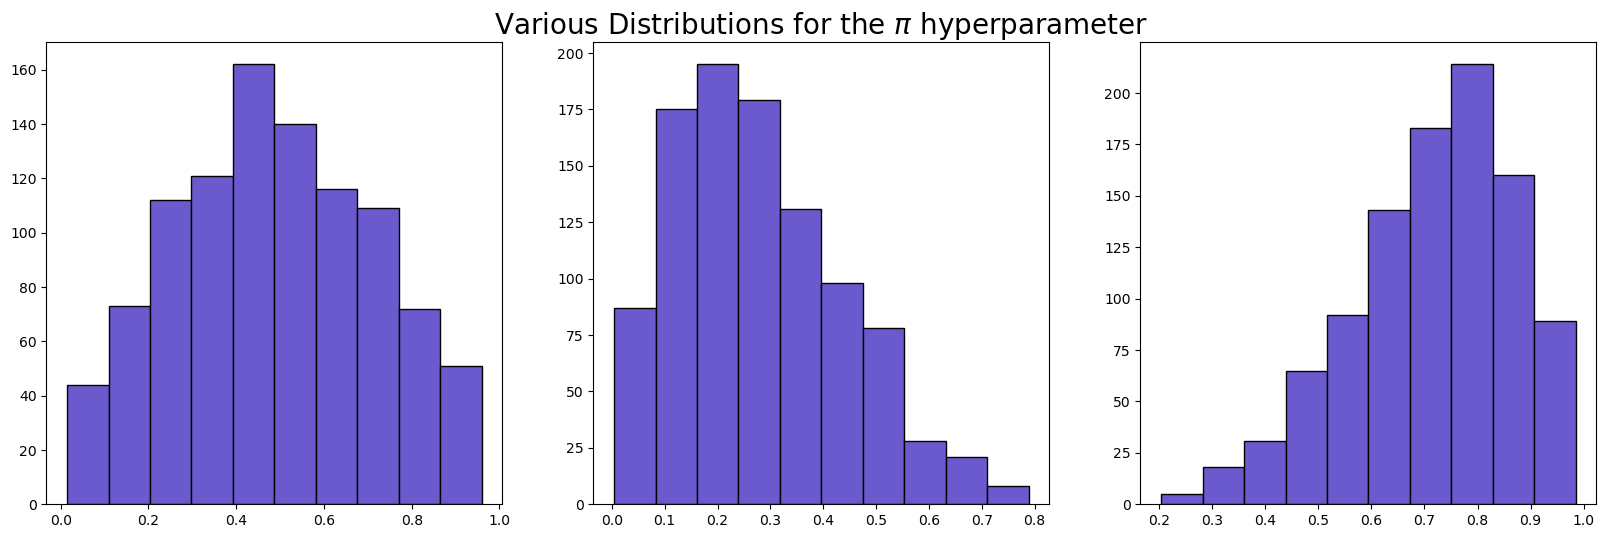

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
axs[0].hist(pm.draw(pm.Beta.dist(2, 2), 1000), ec="black", color="slateblue")
axs[1].hist(pm.draw(pm.Beta.dist(2, 5), 1000), ec="black", color="slateblue")
axs[2].hist(pm.draw(pm.Beta.dist(5, 2), 1000), ec="black", color="slateblue")
axs[1].set_title(r"Various Distributions for the $\pi$ hyperparameter", size=20);

We'll now fit two models and estimate the implied treatment effect.

In [ ]:
sample_kwargs = {
    "draws": 1000,
    "tune": 2000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True,
    "random_seed": 42,
    "mp_ctx": "spawn",
}

# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors (No Variable Selection)")
print("-" * 80)

result_normal = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
)

# =========================================================================
# Model 2: Spike-and-Slab priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 2: Spike-and-Slab Priors")
print("-" * 80)

result_spike_slab = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="spike_and_slab",
    vs_hyperparams={"pi_alpha": 2, "pi_beta": 2, "slab_sigma": 2, "temperature": 0.1},
)


--------------------------------------------------------------------------------
Model 1: Normal Priors (No Variable Selection)
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, beta_z, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 133 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:699: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for beta coefficients. Only 'eta' and 'lkj_sd' will be used.
  warnings.warn(



--------------------------------------------------------------------------------
Model 2: Spike-and-Slab Priors
--------------------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi_beta_t, beta_t_raw, gamma_beta_t_u, pi_beta_z, beta_z_raw, gamma_beta_z_u, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 551 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The models have quite a distinct structure. Compare the normal IV model with non variable selection priors. 

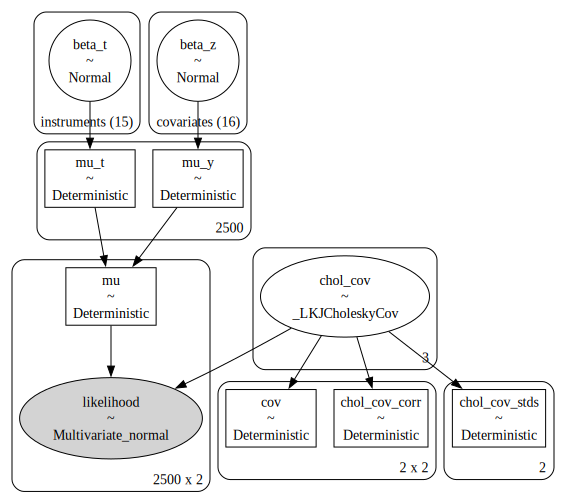

In [17]:
pm.model_to_graphviz(result_normal.model)

Now compare the structure of the spike and slab model. 

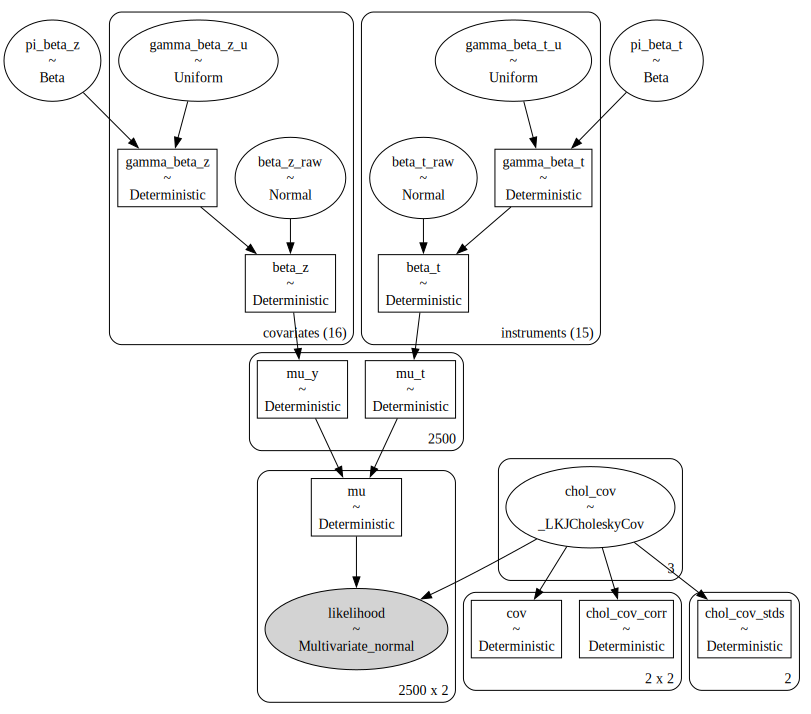

In [18]:
pm.model_to_graphviz(result_spike_slab.model)

Despite seeing some divergences in our spike and slab model, most other sampler health metrics seem healthy

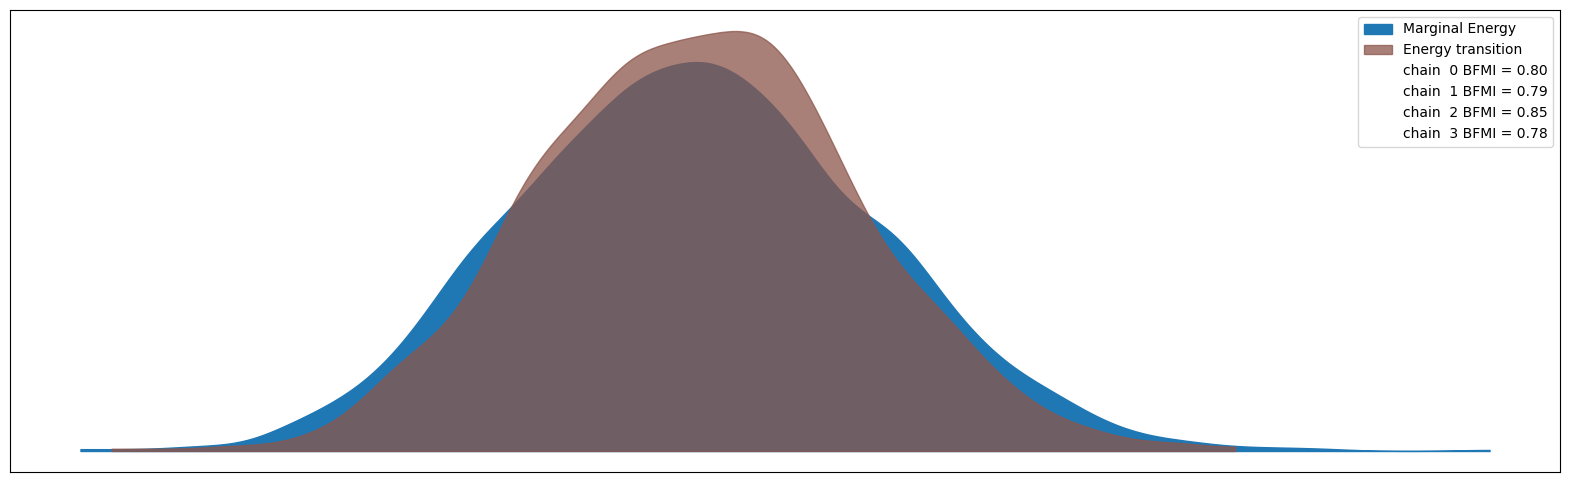

In [21]:
az.plot_energy(result_spike_slab.idata, figsize=(20, 6));

And since we know the true data generating conditions we can also assess the derived posterior treatment estimates. 

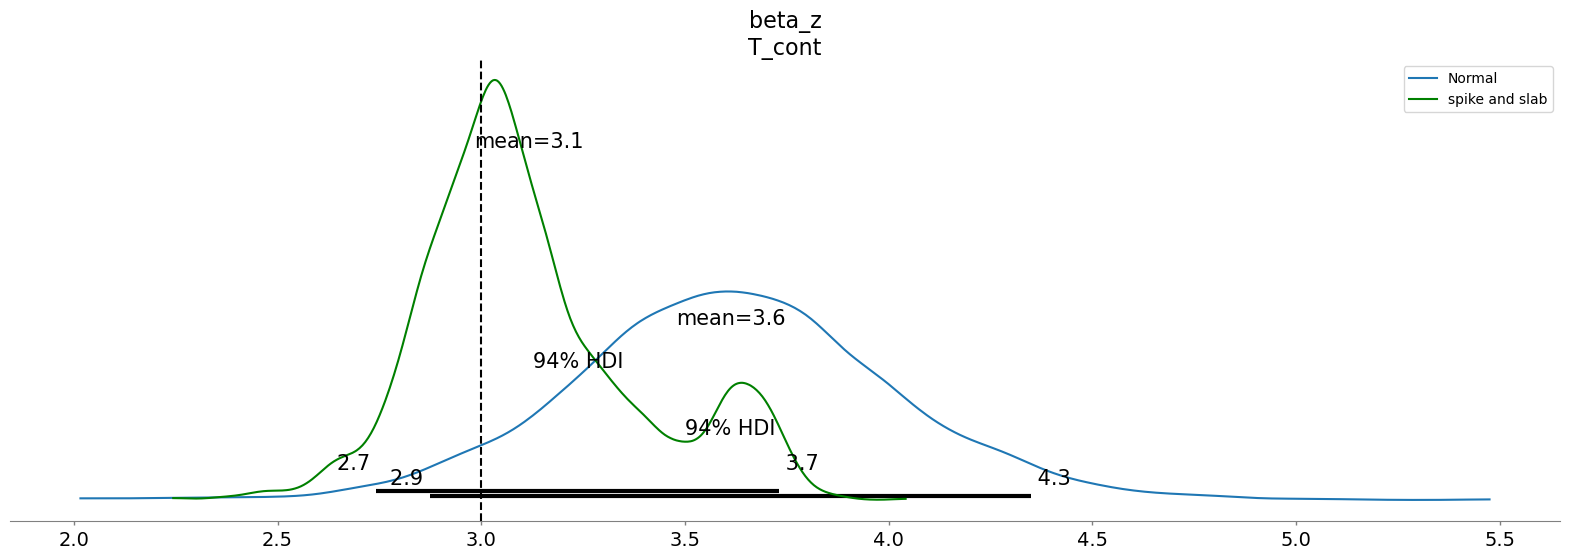

In [26]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
    label="Normal",
)
az.plot_posterior(
    result_spike_slab.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
    color="green",
    label="spike and slab",
)
ax.axvline(3, color="black", linestyle="--", label="True value");

This plot suggests that the spike and slab prior was better able to ignore noise in the process and zero in on the true effect. This will not always work but it is a sensible practice to at least sensitivity check difference between the estimates under different prior settings. We can observe how aggressively the spike and slab prior worked to cull unwanted variables from each model by comparing the values on the coefficients across each model

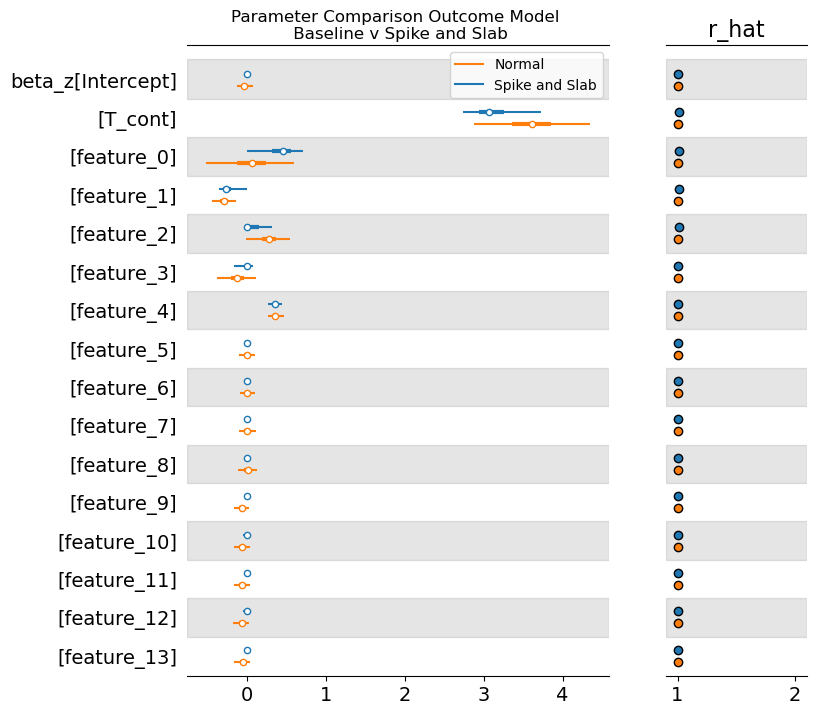

In [15]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_z"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
    r_hat=True,
)
axs[0].set_title("Parameter Comparison Outcome Model \n Baseline v Spike and Slab");

#### The Treatment Model

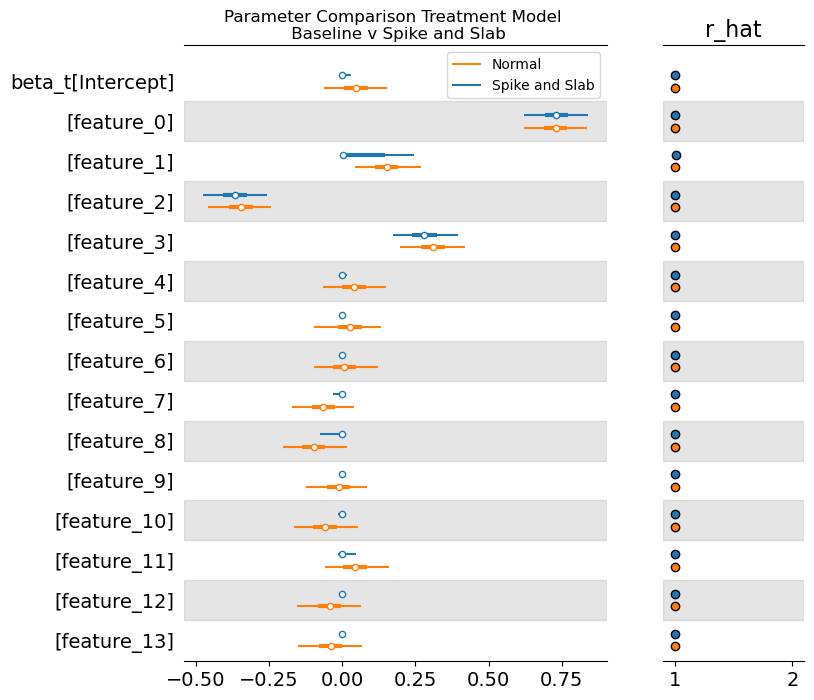

In [16]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_t"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
    r_hat=True,
)

axs[0].set_title("Parameter Comparison Treatment Model \n Baseline v Spike and Slab");

The spike and slab prior can also output direct inclusion probabilities that can be used for communication regarding which variables were "selected" in the process.

In [8]:
summary = result_spike_slab.model.vs_prior_outcome.get_inclusion_probabilities(
    result_spike_slab.idata, "beta_z"
)
summary

,prob,selected,gamma_mean
0,0.01750,False,0.020546
1,1.00000,True,0.991285
2,0.64100,True,0.659357
3,0.58200,True,0.616580
4,0.17625,False,0.192949
5,0.06075,False,0.068297
6,0.66600,True,0.702671
7,0.01000,False,0.012679
8,0.01300,False,0.016342
9,0.00975,False,0.012392


### Horseshoe

The horseshoe prior is a sophisticated continuous shrinkage method designed for regularization and variable selection in high-dimensional regression settings. Unlike discrete selection approaches, it operates through a elegant hierarchical structure that adaptively shrinks coefficients based on the strength of their signal in the data. The key to the implementation is the hierarchical $\lambda$ component: 

$$ \tilde{\lambda}_j = \sqrt{\frac{c^2 \lambda_j^2}{c^2 + \tau^2 \lambda_j^2}} $$

is composed of individual local shrinkage parameters and $c^2$ is a regularization parameter that prevents over-shrinkage of genuinely large signals. 

#### The $\tau_0$ hyperparameter

Like the `temperature` parameter in the spike and slab model, the $\tau_0$ parameter determines the overall level of sparsity expected in the model. However, the $tau_0$ will by default be derived from the data and the number of covariates in your data. While both the horseshoe and spike-and-slab priors address variable selection and sparsity, they embody fundamentally different philosophies about how to achieve these goals. The horseshoe embraces continuity, creating a smooth gradient of shrinkage where all coefficients remain in the model but are pulled toward zero with varying intensity. 

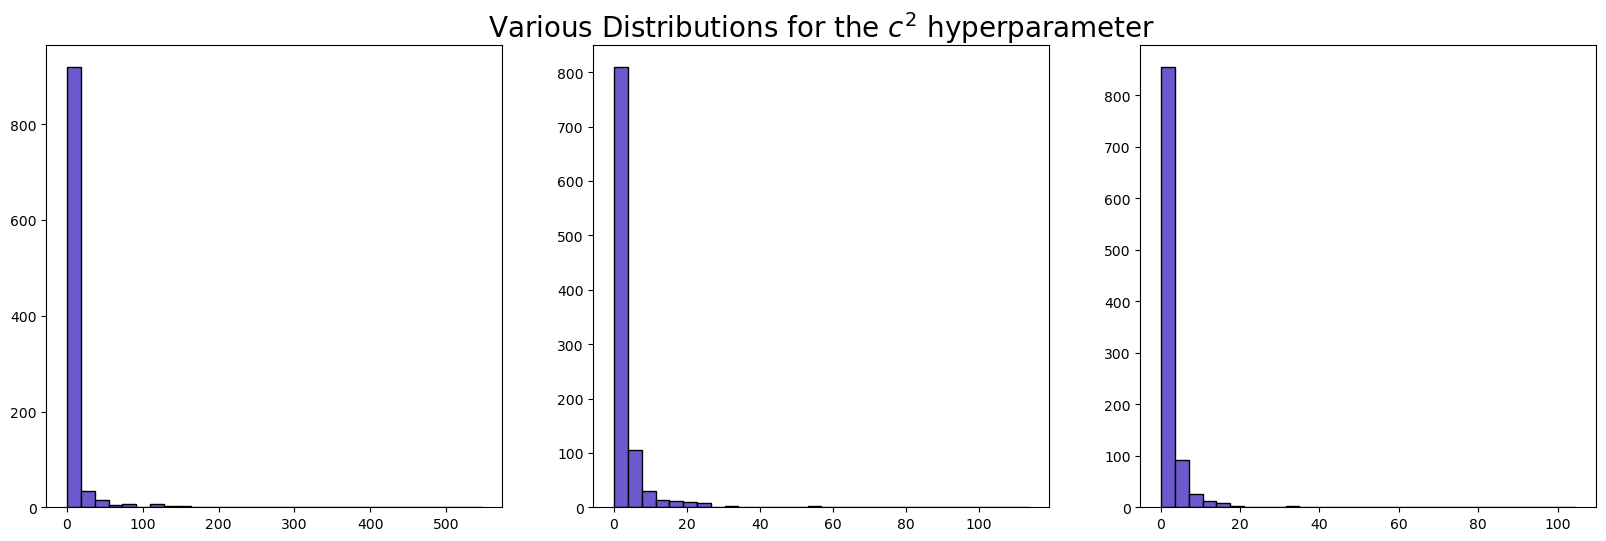

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
axs[0].hist(
    pm.draw(pm.InverseGamma.dist(2, 2), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[1].hist(
    pm.draw(pm.InverseGamma.dist(3, 3), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[2].hist(
    pm.draw(pm.InverseGamma.dist(4, 4), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[1].set_title(r"Various Distributions for the $c^{2}$ hyperparameter", size=20);

In [39]:
# =========================================================================
# Model 2: Horseshoe priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 3: Horseshoe Priors")
print("-" * 80)

result_horseshoe = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="horseshoe",
    vs_hyperparams={"c2_alpha": 3, "c2_beta": 3},
)


--------------------------------------------------------------------------------
Model 3: Horseshoe Priors
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:187: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:699: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for beta coefficients. Only 'eta' and 'lkj_sd' will be used.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_beta_t, lambda_beta_t, c2_beta_t, beta_t_raw, tau_beta_z, lambda_beta_z, c2_beta_z, beta_z_raw, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info

Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 534 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Similar to the inclusion probabilities in the spike and slab model, a horseshoe model can output the relative shrinkage factor that gets applied to each variables inclusion. This method of variable is less decisive than spike and slab, but also mitigates case of completely zero-ing the small but real contributions of certain variables.

In [41]:
summary = result_horseshoe.model.vs_prior_outcome.get_shrinkage_factors(
    result_horseshoe.idata, "beta_z"
)
summary

,shrinkage_factor,lambda_tilde,tau
0,0.014780,1.222524,0.036811
1,0.697739,57.713961,0.036811
2,0.160282,13.257798,0.036811
3,0.129649,10.724023,0.036811
4,0.076676,6.342298,0.036811
5,0.025650,2.121680,0.036811
6,0.190186,15.731398,0.036811
7,0.014198,1.174382,0.036811
8,0.014636,1.210634,0.036811
9,0.014024,1.160002,0.036811


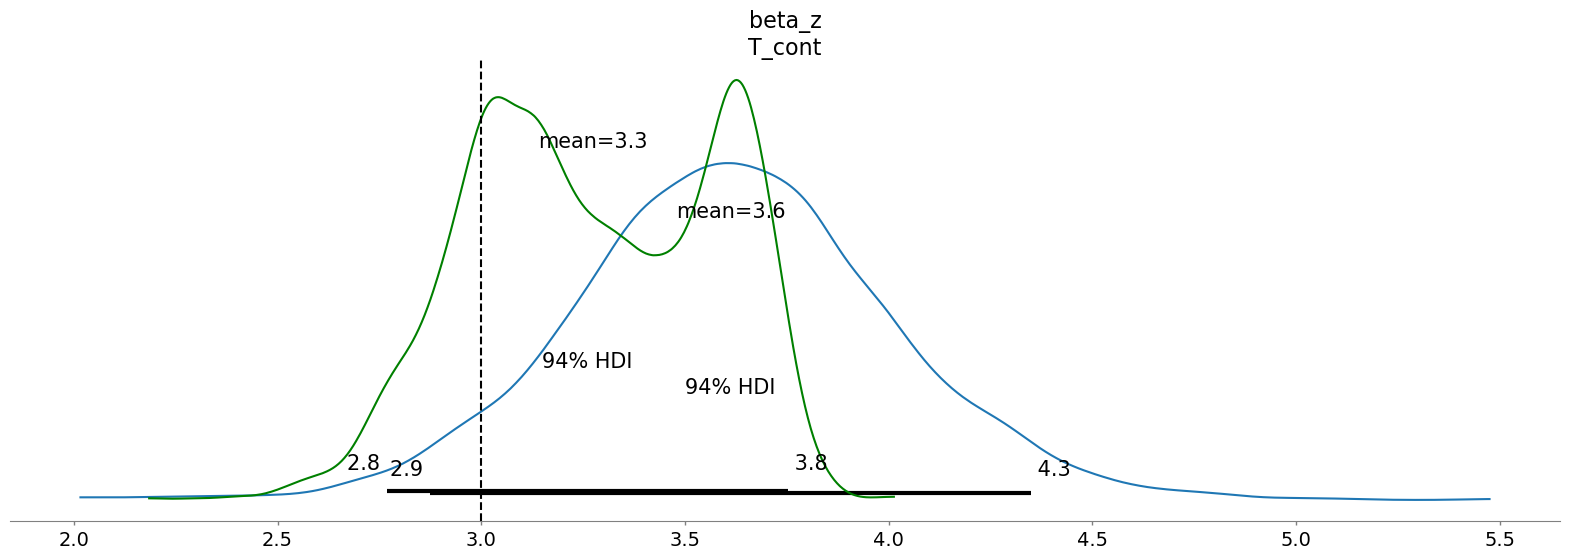

In [53]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata, var_names=["beta_z"], coords={"covariates": ["T_cont"]}, ax=ax
)
az.plot_posterior(
    result_horseshoe.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
    color="green",
)
ax.axvline(3, color="black", linestyle="--");

In this case it seems the horseshoe prior leads a bi-modal posterior estimate of the treatment effect suggesting a kind of indecision about the level of sparsity to apply. 

### Binary Treatment Case

Our data generating function output two different simulation scenarios, where the treatment was either continuous or binary. This allows us to demonstrate the joint modelling of the binary treatment outcome which uses a Bernoulli likelihood for the treatment variable and latent confounding to model the joint realisation of treatment and outcome. 

In [44]:
formula = "Y_bin ~ T_bin + " + " + ".join(features)
instruments_formula = "T_bin ~ 1 + " + " + ".join(features)


# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors Binary Treatment (No Variable Selection)")
print("-" * 80)

result_normal_binary = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
    binary_treatment=True,
)


--------------------------------------------------------------------------------
Model 1: Normal Priors Binary Treatment (No Variable Selection)
--------------------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, beta_z, sigma_U, rho_unconstr, eps_raw]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 68 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


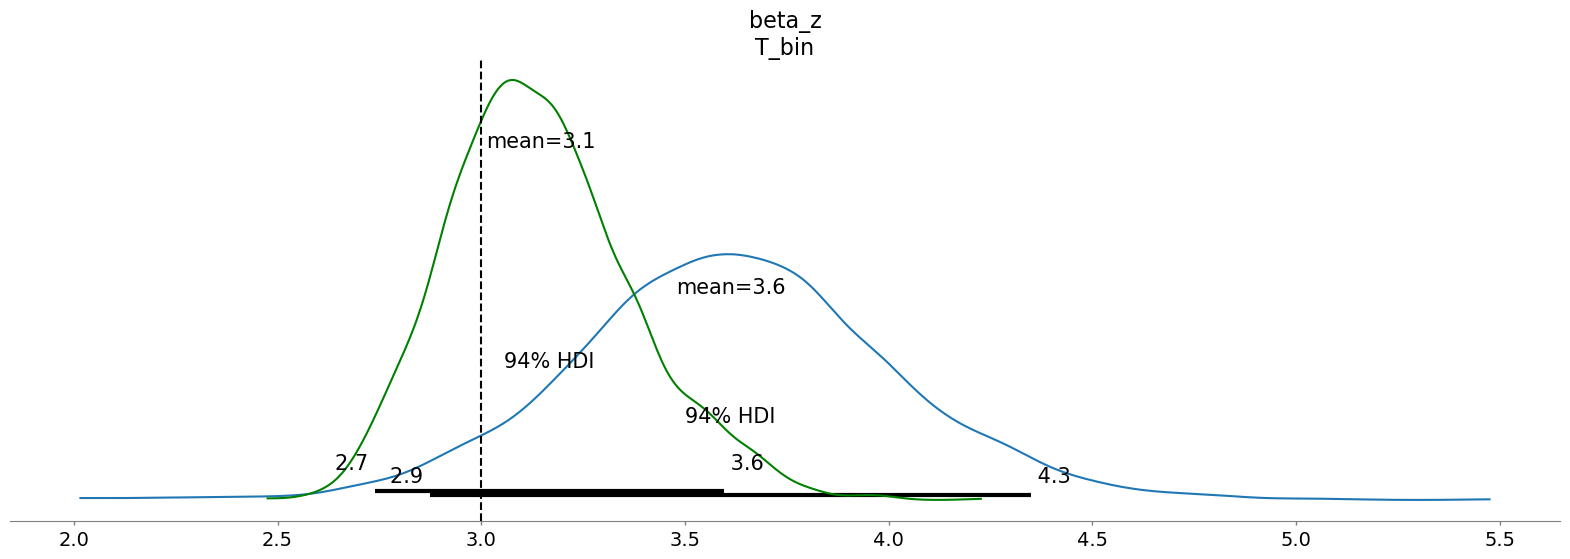

In [46]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata, var_names=["beta_z"], coords={"covariates": ["T_cont"]}, ax=ax
)
az.plot_posterior(
    result_normal_binary.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_bin"]},
    ax=ax,
    color="green",
)
ax.axvline(3, color="black", linestyle="--");


### Conclusion: Choosing Your Path Through Uncertainty

Variable selection priors offer a principled way to navigate the tension between model complexity and causal identification. Rather than forcing binary decisions about which variables to include, these priors encode our uncertainty about variable relevance directly into the inferential framework. But as we've seen, the choice between spike-and-slab and horseshoe reflects deeper commitments about how sparsity manifests in the world.

**The spike-and-slab prior** embodies decisiveness. It asks: which variables truly matter? By pushing coefficients toward exactly zero or allowing them to take on substantial values, it produces interpretable inclusion probabilities that clearly communicate which predictors the model has "selected." This approach shines when you believe that many potential confounders are genuine noise—included out of caution but ultimately irrelevant to the causal mechanism. The discrete nature of selection also makes results easier to communicate to stakeholders who think in terms of "what factors matter?" 

**The horseshoe prior** embraces nuance. It acknowledges that effects exist on a continuum, and that small but real contributions shouldn't be entirely zeroed out. The continuous shrinkage allows weak signals to persist (heavily damped) while strong signals emerge largely unscathed. This is valuable when you suspect that multiple confounders have genuine but varying degrees of influence, and when premature exclusion of any single variable might introduce bias. The regularization parameter $c^2$ acts as a safeguard, preventing even the horseshoe's aggressive shrinkage from overwhelming genuinely large effects.
 
In our simulations, both approaches identified the true treatment effect of 3, though they arrived there differently. The spike-and-slab showed more confidence, producing tighter posterior intervals by decisively excluding noise variables. The horseshoe's bi-modal posterior in some specifications revealed its uncertainty about the appropriate level of sparsity a kind of probabilistic humility that spike-and-slab's discrete choices don't allow.

**Practical Guidance:**
 
- **Use spike-and-slab when** you have strong priors about sparsity (many potential confounders, few true ones), when interpretability matters (stakeholders want to know "what's included?"), or when you're willing to trade some flexibility for more decisive inference.
 
- **Use horseshoe when** you're uncertain about sparsity levels, when small effects might still matter for causal identification, or when you want the model to smoothly adapt its shrinkage to the data without hard inclusion/exclusion decisions.
 
- **Use neither when** theory clearly identifies your confounders, when sample size is large relative to the number of predictors, or when the cost of Type I errors (including irrelevant variables) is low relative to Type II errors (excluding true confounders).
 
**Final Thoughts:**
 
Variable selection priors don't eliminate the need for causal reasoning. They don't tell you which variables are *causally* relevant, only which are *statistically* predictive. But when used thoughtfully—guided by theory about potential confounders, informed by domain knowledge about likely sparsity patterns, and validated through sensitivity analysis. They offer a middle path between the Scylla of over-specification (including everything) and the Charybdis of under-specification (excluding too much). Used within a joint model of treatment and outcome variable, the argument of a variable selection routine  represents an attempt to calibrate the parameters to select the instrument structure. What variable selection is really doing in joint treatment-outcome models is calibrating the parameters to discover patterns consistent with instrument structure *if such structure exists in the data*. The horseshoe shrinks away coefficients that appear redundant given the covariance structure between treatment, outcome, and covariates. The spike-and-slab actively excludes variables that don't contribute to explaining either margin after accounting for shared variation.
 
The ideal use of variable selection in instrumental variable designs is not as a replacement for domain knowledge but as a consistency check. The real power of these methods lies not in automation but in transparency. By making variable selection part of the posterior distribution rather than a pre-processing step, we can quantify and communicate our uncertainty about model structure itself. This moves us closer to the goal of all principled causal inference: not just estimating effects, but understanding the limits of what we can learn from the data we have.
 
As always in causal inference, the model is a question posed to the data. Variable selection priors help us ask that question more precisely, but we still need theory to tell us if we're asking the right question at all.

